<div class="jupyter-biolm-header">
    <img style="float: left; padding-right: 10px; height: 60px" src="https://d31e6ufxekikrt.cloudfront.net/static/ui/images/logo.png">
    <p>
    <br>
    <br>
    <br>
    </p>
</div>

# Antibody Engineering

Comprehensive antibody engineering workflow using BioLM.ai models.

Antibodies are highly specific proteins with incredible binding prowess, important immune mediated interactions and high therapuetic potential. Benefiting from recent machine learning success in biology, and specifically protein design , computational antibody engineering has become extremely accessible. In the following guides, motivated by the binder design challenges proposed with the BenchBB dataset and the expediency of the BioLM SDK and API, several ML methods for antibody engineering are demonstrated.

Binder design is largely partisan to two categories, de-novo binder and variant (also called diversified) binder design. 

---

- **variant binder design** revolves around modifying existing antibodies already posessing desirable properties inorder to improve certain capabilities. These properies could be a stable / non immunogenic framework, already present binding capability, etc. These methods require an existing moelcule to base further development off of and are thus limited to a smaller design space.
- **de-novo binder design**, is the novel and disimilar creation of protien binder. It has the advantages of potentially circumventing evolutionary and historical constraints accessing a larger design space as well as side-stepping IP concerns. Fully de-novo antibody design if intended for therapuetic use may run immunogenic risks requiring further humanization. For this reason many antibody engineering efforts restric themselves to the CDRs and surronding regions


These first series of guides will focus on variant design methods. Four of the proposed BenchBB targets ('IL7Ra', 'PDL-1', 'EGFR' and 'MBP') have solved structures of antibodies in complex with the target deposited in the pdb.

## Import Required Libraries

In [2]:
from IPython.display import JSON
import requests
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pathlib import Path
from sklearn.decomposition import PCA
from Bio import PDB
from Bio.PDB import *

from biolmai import BioLM
from helpers.styling import apply_plot_styling
apply_plot_styling()

## Machine Learning Based Cadidate Proposal for Antibody Engineering

A key component in variant binder design is candidate proposal. Starting with the base protein, variants are created with substitutions, insertions and deletions with the goal of maintaining the functionality of that base protein while potentially improving on important parameters. How those modifications are proposed though has a significant impact on resource cost and success rate. If these variants were proposed by random modification, the candidate space becomes tremendous, scaling exponentially with the number of mutations n, and evaluation of those candidates becomes computationally intractable. Smart heuristics and clever sampling schemes can bring the number of candidates down to manageable levels while maintaining a relatively high expectation of success. One way to do this is to use ML methods to sample the space drawing from models 'learning' the distribution of functional and evolutionarily plausable proteins. The ideal proposal method would only propose functional candiates meeting all desired specifications and properties. A realistic proposal method can be thought of as proposing 'likely' candidates at a scale that can be passed through other additional filters before selecting variants with high confidence to be experimentally tested.

Since the ultimate goal is binding, AntiFold, an inverse folding method that conditions on existing antibody structure and antigen complexes, is selected to generate cnadidate antibody sequences. Four IMGT annotated PDBs corresponding to the targets from the BenchBB dataset are read into strings and then processed by the BioLM SDK.

In [58]:
# Load PDBs from BenchBB dataset
target_pdbs = {}
pdb_dir = Path('data/protein/benchbb_antibody_targets')

for pdb_file in os.listdir(pdb_dir):
    if pdb_file.endswith('.pdb'):
        if '3c09' in pdb_file:
            target = 'EGFR'
        elif '5x8m' in pdb_file:
            target = 'PDL1'
        elif '5bjz' in pdb_file:
            target = 'MBP'
        elif '6p67' in pdb_file:
            target = 'IL-7RALPHA'
        else:
            continue
        
        # Store PDB string
        with open(pdb_dir / pdb_file, 'r') as f:
            target_pdbs[target] = f.read()

print(f"Loaded PDBs for targets: {list(target_pdbs.keys())}")

Loaded PDBs for targets: ['MBP', 'EGFR', 'PDL1', 'IL-7RALPHA']


In [59]:
from biotite.structure.io.pdb import PDBFile, get_structure
from biotite.structure.residues import get_residues
from biotite.structure.info import one_letter_code
from io import StringIO

# Explicit set of valid 3-letter residue names with defined 1-letter codes
VALID_RESIDUES = {
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY",
    "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER",
    "THR", "TRP", "TYR", "VAL"
}

def extract_sequences_from_pdb_str(pdb_str, chain_ids, verbose=False):
    """
    Extract ATOM-derived one-letter sequences from specified chains in a PDB string.
    
    Returns:
      dict: {chain_id: sequence_string}
    """
    pdbf = PDBFile.read(StringIO(pdb_str))
    structure = get_structure(pdbf, model=1)

    seqs = {}
    for chain in chain_ids:
        chain_array = structure[structure.chain_id == chain]
        if chain_array.array_length() == 0:
            print(f"⚠️ No atoms for chain '{chain}'")
            continue

        res_ids, res_names = get_residues(chain_array)
        if len(res_ids) == 0:
            print(f"⚠️ No residues found in chain '{chain}'")
            continue

        seq = ''
        for name in res_names:
            if name in VALID_RESIDUES:
                seq += one_letter_code(name)
            else:
                if verbose:
                    print(f"⚠️ Unknown residue '{name}' → skipping")
                # or optionally: seq += 'X'
        seqs[chain] = seq

    return seqs





target_chains = {
    "EGFR": ['H', 'L', 'D'],
    "PDL1": ['B', 'C', 'A'],
    "MBP": ['C', 'L', 'A'],
    "IL-7RALPHA": ['A', 'B', 'K'],
}



# Extract sequences
target_chain_seqs = {}
for target, pdb_str in target_pdbs.items():
    chains = target_chains[target]
    target_chain_seqs[target] = extract_sequences_from_pdb_str(pdb_str, chains)

# Example printout
for target, chain_dict in target_chain_seqs.items():
    print(f"\n{target}:")
    for chain_id, seq in chain_dict.items():
        print(f"  Chain {chain_id}: {seq[:30]}... (length {len(seq)})")


MBP:
  Chain C: EVQLVESGGGLVQPGGSLRLSCAASGFNLS... (length 228)
  Chain L: QMTQSPSSLSASVGDRVTITCRASQSVSSA... (length 213)
  Chain A: KIEEGKLVIWINGDKGYNGLAEVGKKFEKD... (length 367)

EGFR:
  Chain H: QVQLVQSGAEVKKPGASVKVSCKASGYTFT... (length 216)
  Chain L: DIQMTQSPSSLSASVGDRVTITCSASSSVT... (length 211)
  Chain D: KKVCNGIGIGEFKDSLSINATNIKHFKNCT... (length 191)

PDL1:
  Chain B: EVQLVESGGGLVQPGGSLRLSCAASGFTFS... (length 214)
  Chain C: IVLTQSPGTLSLSPGERATLSCRASQRVSS... (length 213)
  Chain A: AFTVTVPKDLYVVEYGSNMTIECKFPVEKE... (length 116)

IL-7RALPHA:
  Chain A: EVQLQQSGPELVKPGASVKMSCKASGYTFS... (length 223)
  Chain B: DIVMTQSHKFMSTLVGDRVSITCKASQDVS... (length 213)
  Chain K: DYSFSCYSQLEVNGSQHSLTCAFEDPDVNT... (length 188)


Now that the pdb strings are in memory additional parameters including which chains correspond to the antibody heavy and light chains or the target are specified. The regions of the antibody to be (re)designed are selected as well as the number of returned variants. 

In [60]:
# Generate variants using AntiFold

payloads = {}


payloads['EGFR'] = {
        "params": {
    "num_seq_per_target": 100,
    "sampling_temp": 0.8,
    "regions": [
      "CDR1",
      "CDR2",
      "CDR3"
    ],
    "light_chain": "L",
    "heavy_chain": "H",
    "antigen_chain": "D"
  },
        "items": [
            {
                "pdb": target_pdbs['EGFR']
            }
        ]
    }




payloads['PDL1'] = {
        "params": {
    "num_seq_per_target": 100,
    "sampling_temp": 0.8,
    "regions": [
      "CDR1",
      "CDR2",
      "CDR3"
    ],
    "light_chain": "C",
    "heavy_chain": "B",
    "antigen_chain": "A"
  },
        "items": [
            {
                "pdb": target_pdbs['PDL1']
            }
        ]
    }



payloads['MBP']= {
        "params": {
    "num_seq_per_target": 100,
    "sampling_temp": 0.8,
    "regions": [
      "CDR1",
      "CDR2",
      "CDR3"
    ],
    "light_chain": "L",
    "heavy_chain": "C",
    "antigen_chain": "A"
  },
        "items": [
            {
                "pdb": target_pdbs['MBP']
            }
        ]
    }


payloads['IL-7RALPHA'] = {
        "params": {
    "num_seq_per_target": 100,
    "sampling_temp": 0.8,
    "regions": [
      "CDR1",
      "CDR2",
      "CDR3"
    ],
    "light_chain": "B",
    "heavy_chain": "A",
    "antigen_chain": "K"
  },
        "items": [
            {
                "pdb": target_pdbs['IL-7RALPHA']
            }
        ]
    }


Submitting the pdbs and params to the BioLM SDK generates 100 variants for each target along with model specific metrics like score and global_score.

In [6]:
samples_dfs = []
for target, pdb_str in target_pdbs.items():
    
    start = time.time()
    result = BioLM(entity="antifold", action="generate", items=payloads[target]["items"], params=payloads[target]["params"])
    end = time.time()
    print(f"Antifold generation took {end - start:.4f} seconds.")
    samples_df = pd.DataFrame(result['sequences'])
    samples_df["target"] = target
    samples_dfs.append(samples_df)
    
    print(f"Generated {len(samples_df)} variants for {target}")
samples_dfs = pd.concat(samples_dfs)

Antifold generation took 43.8358 seconds.
Generated 100 variants for MBP
Antifold generation took 19.3139 seconds.
Generated 100 variants for EGFR
Antifold generation took 21.2159 seconds.
Generated 100 variants for PDL1
Antifold generation took 22.7458 seconds.
Generated 100 variants for IL-7RALPHA


Now that the variants are generated, the exact differences can be inspected to make sure the parameters of the generation method were correctly followed. Multiple sequence alignments and CDR extraction are great tools to examing differences among variants especially considering the conserved framworks.  Visualizing 10 of the variants against the parent heavy sequence.

In [18]:
import biotite.sequence as seq
import biotite.sequence.align as align
import biotite.sequence.graphics as graphics


sequences = dict(zip(
    ["P"] + samples_dfs[samples_dfs["target"] == "EGFR"].index.tolist()[:9],
    [target_chain_seqs["EGFR"]["H"]] + samples_dfs[samples_dfs["target"] == "EGFR"]["heavy"].tolist()[:9]
))

# Convert to ProteinSequence objects
protein_seqs = [seq.ProteinSequence(s) for s in sequences.values()]

# Now run align_multiple
alignment, order, guide_tree, distance_matrix = align.align_multiple(
    protein_seqs,
    matrix=align.SubstitutionMatrix.std_protein_matrix(),
    gap_penalty=-5,
)

# Order alignment according to guide tree
alignment = alignment[:, order.tolist()]


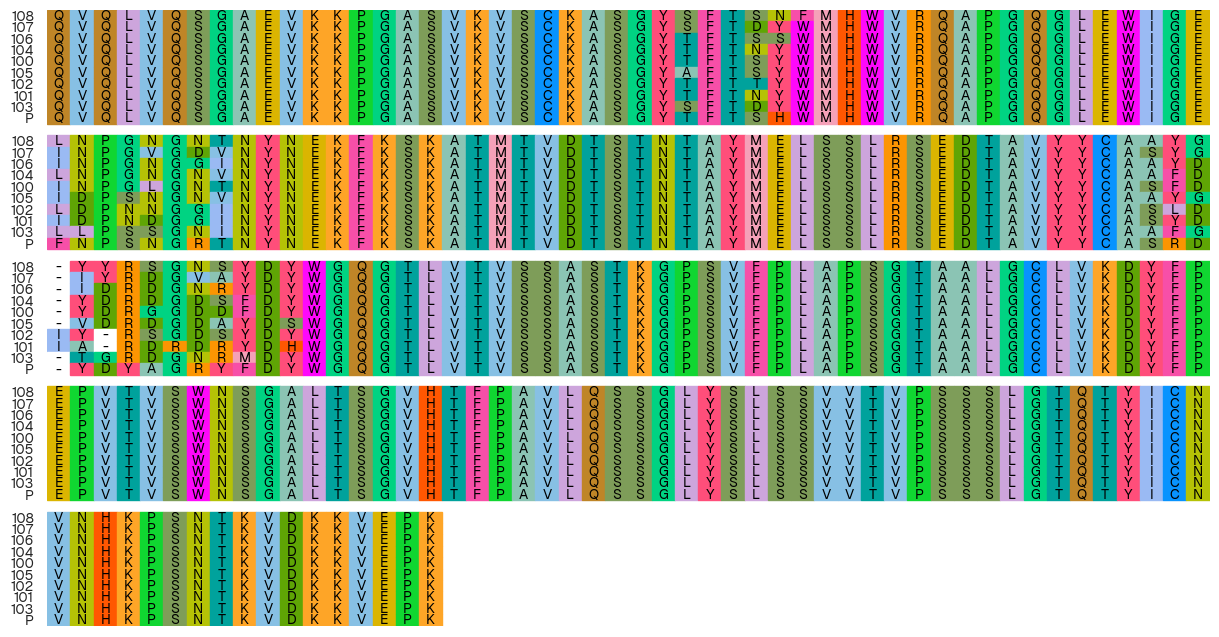

In [19]:
labels = np.array(list(sequences.keys()))[order]
fig, ax = plt.subplots(figsize=(15.0, 8.0), constrained_layout=False)
graphics.plot_alignment_type_based(
    ax, alignment, color_scheme="blossom",
    symbols_per_line=50, symbol_size=10,
    labels=labels, label_size=10,
)

Visualizing the differences in the variants compared to the parent sequence, all of the variability is contained within the CDR regions as expected. Utitlizing ANARCI renumbering to extract the unique CDRS (Alternatively the BioLM SADIE-Antibody API can also do this). EX 

```python
sadie_heavy = pd.DataFrame(BioLM(entity="sadie-antibody", action="predict", type="sequence", items=samples_dfs["heavy"].tolist(), params = {"allowed_chain": ["H"]}))
sadie_light = pd.DataFrame(BioLM(entity="sadie-antibody", action="predict", type="sequence", items=samples_dfs["heavy"].tolist(),  params = {"allowed_chain": ["K", "L"]}))

```

In [42]:
import pandas as pd
from abnumber import Chain

def extract_cdrs_abnumber(df, heavy_col='heavy', light_col='light', scheme='chothia'):
    def extract_cdrs(seq):
        if pd.isna(seq) or not seq:
            return {'cdr1': None, 'cdr2': None, 'cdr3': None}
        try:
            chain = Chain(seq, scheme=scheme)
            return {
                'cdr1': chain.cdr1_seq,
                'cdr2': chain.cdr2_seq,
                'cdr3': chain.cdr3_seq
            }
        except Exception as e:
            print(f"Failed to extract CDRs: {e}")
            return {'cdr1': None, 'cdr2': None, 'cdr3': None}

    cdr_data = []
    for _, row in df.iterrows():
        heavy_cdrs = extract_cdrs(row.get(heavy_col))
        light_cdrs = extract_cdrs(row.get(light_col))

        cdr_data.append({
            'heavy_cdr1': heavy_cdrs['cdr1'],
            'heavy_cdr2': heavy_cdrs['cdr2'],
            'heavy_cdr3': heavy_cdrs['cdr3'],
            'light_cdr1': light_cdrs['cdr1'],
            'light_cdr2': light_cdrs['cdr2'],
            'light_cdr3': light_cdrs['cdr3'],
        })

    cdr_df = pd.DataFrame(cdr_data)
    return pd.concat([df.reset_index(drop=True), cdr_df], axis=1)



In [43]:
df_cdrs = extract_cdrs_abnumber(samples_dfs)

Visualizing the CDRs, we see the most diversity in CDR H3 the longest CDR and a region often highly responsible for much of an antibodies binding strength, there is mroe significant overlap among variants in the other CDR regions.

In [48]:
df_melt = df_cdrs.melt(
    value_vars=[
        'heavy_cdr1', 'heavy_cdr2', 'heavy_cdr3',
        'light_cdr1', 'light_cdr2', 'light_cdr3'
    ],
    var_name='Chain_CDR',
    value_name='CDR_Seq'
)

# Extract 'Chain' and 'CDR' from the column names
df_melt['Chain'] = df_melt['Chain_CDR'].apply(lambda x: 'heavy' if 'heavy' in x else 'light')
df_melt['CDR'] = df_melt['Chain_CDR'].apply(lambda x: 'CDR1' if 'cdr1' in x else ('CDR2' if 'cdr2' in x else 'CDR3'))

# Count unique sequences
cdr_counts = (
    df_melt.groupby(['Chain', 'CDR'])['CDR_Seq']
    .nunique()
    .reset_index()
    .rename(columns={'CDR_Seq': 'Unique_Count'})
)

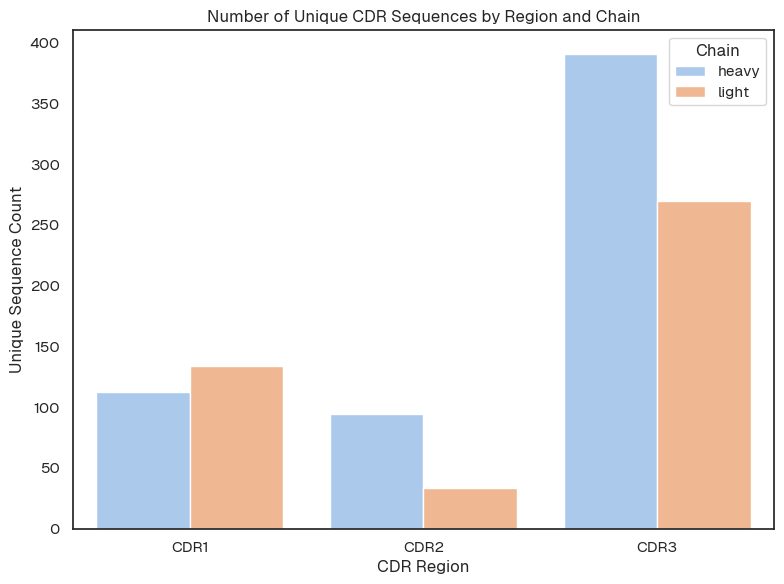

In [49]:
plt.figure(figsize=(8, 6))
sns.barplot(data=cdr_counts, x='CDR', y='Unique_Count', hue='Chain')
plt.title('Number of Unique CDR Sequences by Region and Chain')
plt.ylabel('Unique Sequence Count')
plt.xlabel('CDR Region')
plt.tight_layout()
plt.show()

Now that the sequences of the varainats have been examined, the data and scores returned by the AntiFold response can be visualized. The varaiants for each target seem to follow some clear patterns. The score and global score have a similar thread across targets and the number of mutations does not exceed much past 30, or approximately 10% of the sequences modified (consistent with the 3 CDRs for heavy and 3 CDRs for light chains being targeted).

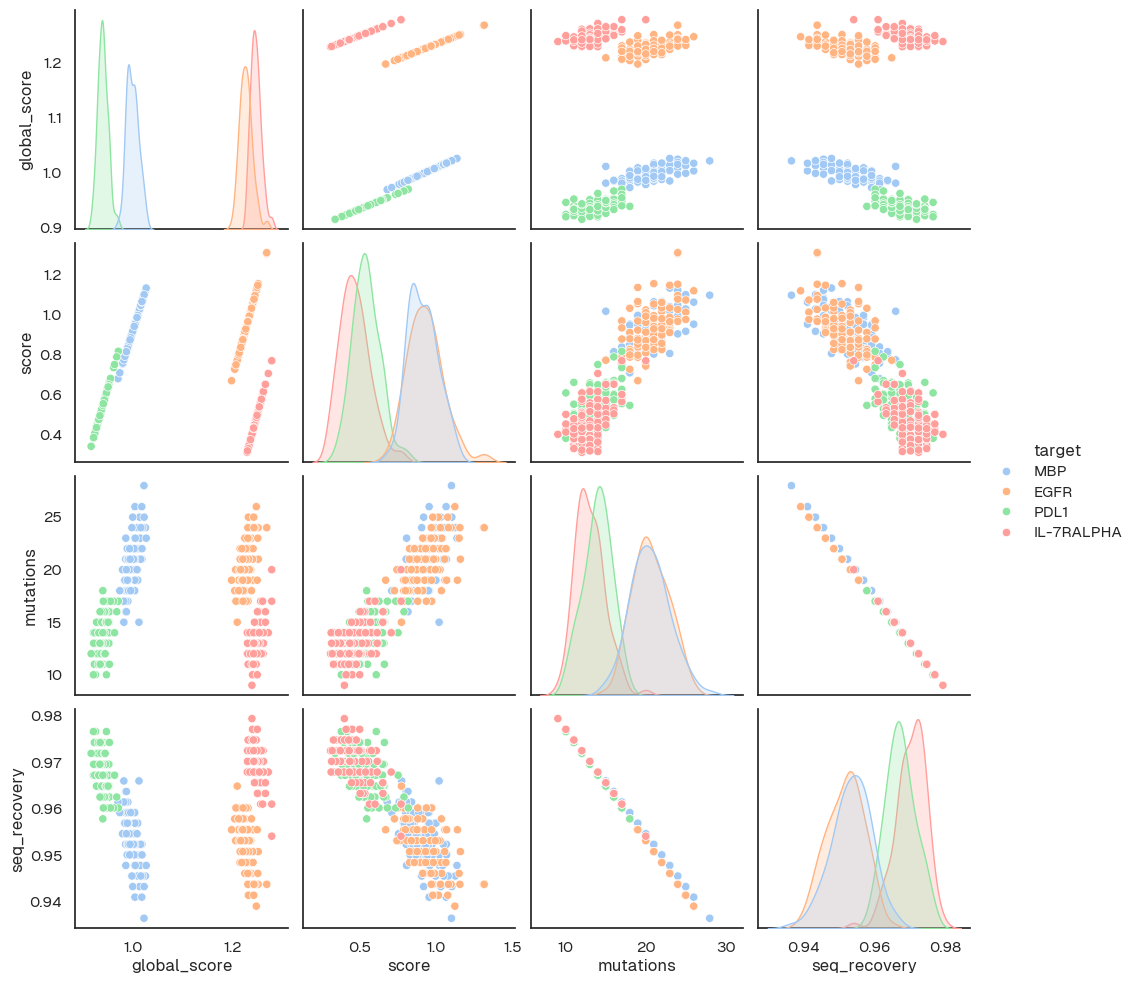

In [50]:
features = ['global_score', 'score', 'mutations',
       'seq_recovery']
targets = ['target']
g = sns.pairplot(samples_dfs[features + targets], hue='target')

Finally these candidates are saved for further scoring and evaluation through additional machine learning based antibody methods.

In [53]:
df_cdrs[["heavy", "light", "global_score", "score", "mutations", "seq_recovery", "target",'heavy_cdr1', 'heavy_cdr2', 'heavy_cdr3',
        'light_cdr1', 'light_cdr2', 'light_cdr3']].to_csv("data/protein/benchbb_antibody_targets/variant_candidates.csv", index=False)